## __0. Download dataset__
**Note:** If you can't download using gdown due to limited number of downloads, please download it manually and upload it to your drive, then copy it from the drive to colab.
```python
from google.colab import drive

drive.mount('/content/drive')
!cp /path/to/dataset/on/your/drive .
```

In [1]:
# https://drive.google.com/file/d/1kc6XNqHZJg27KeBuoAoYj70_1rT92191/view?usp=sharing
!gdown --id 1kc6XNqHZJg27KeBuoAoYj70_1rT92191

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1kc6XNqHZJg27KeBuoAoYj70_1rT92191
From (redirected): https://drive.google.com/uc?id=1kc6XNqHZJg27KeBuoAoYj70_1rT92191&confirm=t&uuid=cf426e31-d97c-4515-b1c9-23c94055bd5c
To: /content/vqa_coco_dataset.zip
100% 196M/196M [00:03<00:00, 55.8MB/s]


In [2]:
!unzip -q vqa_coco_dataset.zip

## __1. Import libraries and set random seed__

In [3]:
!pip install timm==0.8.17.dev0
!pip install torchtext==0.15.1
!pip install torchvision==0.16.0
!pip install torchaudio==2.1.0
!pip install torch==2.1.0
!pip install transformers==4.27.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.3 MB/s eta 0:00:00
  Attempting uninstall: timm
    Found existing installation: timm 1.0.12
    Uninstalling timm-1.0.12:
      Successfully uninstalled timm-1.0.12
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 66.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.4 

In [4]:
import torch
import torch.nn as nn
import torchtext
import os
import random
import numpy as np
import pandas as pd
import spacy
import timm
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchvision import transforms

In [5]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 59
set_seed(seed)

## __2. Read dataset__

In [15]:
train_data = []
train_set_path = 'vaq2.0.TrainImages.txt'

with open(train_set_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        temp = line.split('\t')
        qa = temp[1].split('?')

        if len(qa) == 3:
            answer = qa[2].strip()
        else:
            answer = qa[1].strip()

        data_sample = {
            'image_path': temp[0][:-2],
            'question': qa[0] + '?',
            'answer': answer
        }
        train_data.append(data_sample)

In [17]:
test_data = []
test_set_path = "/content/vaq2.0.DevImages.txt"

with open(train_set_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        temp = line.split('\t')
        qa = temp[1].split('?')

        if len(qa) == 3:
            answer = qa[2].strip()
        else:
            answer = qa[1].strip()

        data_sample = {
            'image_path': temp[0][:-2],
            'question': qa[0] + '?',
            'answer': answer
        }
        val_data.append(data_sample)

## __3. Data Preprocessing__

In [18]:
eng = spacy.load("en_core_web_sm")

def get_tokens(data_iter):
    for sample in data_iter:
        question = sample['question']

        yield [token.text for token in eng.tokenizer(question)]


vocab = build_vocab_from_iterator(
    get_tokens(train_data),
    min_freq=2,
    specials= ['<pad>', '<sos>', '<eos>', '<unk>'],
    special_first=True
)
vocab.set_default_index(vocab['<unk>'])

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [19]:
len(vocab)

1678

In [20]:
def tokenize(question, max_seq_len):
    tokens = [token.text for token in eng.tokenizer(question)]
    sequence = [vocab[token] for token in tokens]
    if len(sequence) < max_seq_len:
        sequence += [vocab['<pad>']] * (max_seq_len - len(sequence))
    else:
        sequence = sequence[:max_seq_len]

    return sequence

In [21]:
def detokenize(sequence):
    idx_to_token = vocab.get_itos()

    tokens = [idx_to_token[idx] for idx in sequence if idx_to_token[idx] not in ['<pad>', '<sos>', '<eos>', '<unk>']]

    return " ".join(tokens)

In [22]:
classes = set([sample['answer'] for sample in train_data])
label2idx = {
    cls_name: idx for idx, cls_name in enumerate(classes)
}
idx2label = {
    idx: cls_name for idx, cls_name in enumerate(classes)
}
print(idx2label)

{0: 'no', 1: 'yes'}


## __4. Create Pytorch dataset__

In [23]:
class VQADataset(Dataset):
    def __init__(
        self,
        data,
        label2idx,
        max_seq_len=20,
        transform=None,
        img_dir='val2014-resised/'
    ):
        self.transform = transform
        self.data = data
        self.label2idx = label2idx
        self.max_seq_len = max_seq_len
        self.img_dir = img_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir,
                                self.data[index]['image_path'])
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        question = self.data[index]['question']
        question = tokenize(question, self.max_seq_len)
        question = torch.tensor(question, dtype=torch.long)

        label = self.data[index]['answer']
        label = self.label2idx[label]
        label = torch.tensor(label, dtype=torch.long)

        return img, question, label

In [24]:
data_transform = {
    'train': transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.CenterCrop(size=180),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        transforms.RandomHorizontalFlip(),
        transforms.GaussianBlur(3),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]),
    'val': transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
}

In [25]:
train_dataset = VQADataset(
    train_data,
    label2idx=label2idx,
    transform=data_transform['train']
)
val_dataset = VQADataset(
    val_data,
    label2idx=label2idx,
    transform=data_transform['val']
)
test_dataset = VQADataset(
    test_data,
    label2idx=label2idx,
    transform=data_transform['val']
)

In [26]:
train_batch_size = 256
test_batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

## __5. Create VQA model__

In [28]:
class VQAModel(nn.Module):
    def __init__(
        self,
        n_classes,
        img_model_name,
        embeddding_dim,
        n_layers=2,
        hidden_size=256,
        drop_p=0.2
    ):
        super(VQAModel, self).__init__()
        self.image_encoder = timm.create_model(
            img_model_name,
            pretrained=True,
            num_classes=hidden_size
        )

        for param in self.image_encoder.parameters():
            param.requires_grad = True

        self.embedding = nn.Embedding(len(vocab), embeddding_dim)
        self.lstm1 = nn.LSTM(
            input_size=embeddding_dim,
            hidden_size=hidden_size,
            num_layers=n_layers,
            dropout=drop_p,
            batch_first=True,
            bidirectional=True
        )
        self.fc1 = nn.Linear(hidden_size * 3, hidden_size)
        self.dropout = nn.Dropout(drop_p)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(hidden_size, n_classes)

    def forward(self, img, text):
        img_features = self.image_encoder(img)

        text_emb = self.embedding(text)
        lstm_out, _ = self.lstm1(text_emb)

        lstm_out = lstm_out[:, -1, :]

        combined = torch.cat((img_features, lstm_out), dim=1)
        x = self.fc1(combined)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [29]:
n_classes = len(classes)
img_model_name = 'resnet18'
hidden_size = 256
n_layers = 2
embeddding_dim = 128
drop_p = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = VQAModel(
    n_classes=n_classes,
    img_model_name=img_model_name,
    embeddding_dim=embeddding_dim,
    n_layers=n_layers,
    hidden_size=hidden_size,
    drop_p=drop_p
).to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [30]:
images, questions, labels = next(iter(train_loader))

model.eval()
with torch.no_grad():
    images = images.to(device)
    questions = questions.to(device)
    output = model(images, questions)
    print(output.shape)

torch.Size([256, 2])


## __6. Training__

In [37]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for image, question, labels in dataloader:
            image, question, labels = image.to(device), question.to(device), labels.to(device)
            outputs = model(image, question)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    if len(losses) == 0:
        print("Warning: The dataloader is empty, returning loss and accuracy as 0.")
        return 0, 0

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [32]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (images, questions, labels) in enumerate(train_loader):
            images = images.to(device)
            questions = questions.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images, questions)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            model, val_loader,
            criterion, device
        )
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}\tVal Acc: {val_acc}')

        scheduler.step()

    return train_losses, val_losses

In [33]:
lr = 1e-3
epochs = 30

scheduler_step_size = epochs * 0.8
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=scheduler_step_size,
    gamma=0.1
)

In [34]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
)

EPOCH 1:	Train loss: 0.7003	Val loss: 0.7202	Val Acc: 0.5021667091511598
EPOCH 2:	Train loss: 0.6939	Val loss: 0.6920	Val Acc: 0.5173336732092786
EPOCH 3:	Train loss: 0.6937	Val loss: 0.6947	Val Acc: 0.5258730563344379
EPOCH 4:	Train loss: 0.6932	Val loss: 0.6931	Val Acc: 0.5217945449910782
EPOCH 5:	Train loss: 0.6931	Val loss: 0.6895	Val Acc: 0.5372164160081571
EPOCH 6:	Train loss: 0.6925	Val loss: 0.6916	Val Acc: 0.524343614580678
EPOCH 7:	Train loss: 0.6915	Val loss: 0.6918	Val Acc: 0.513764975783839
EPOCH 8:	Train loss: 0.6915	Val loss: 0.6940	Val Acc: 0.5168238592913587
EPOCH 9:	Train loss: 0.6915	Val loss: 0.6902	Val Acc: 0.5323731837879174
EPOCH 10:	Train loss: 0.6894	Val loss: 0.6944	Val Acc: 0.5151669640581188
EPOCH 11:	Train loss: 0.6905	Val loss: 0.6913	Val Acc: 0.5392556716798369
EPOCH 12:	Train loss: 0.6894	Val loss: 0.6905	Val Acc: 0.524343614580678
EPOCH 13:	Train loss: 0.6909	Val loss: 0.6890	Val Acc: 0.5288044863624777
EPOCH 14:	Train loss: 0.6889	Val loss: 0.6881	Val 

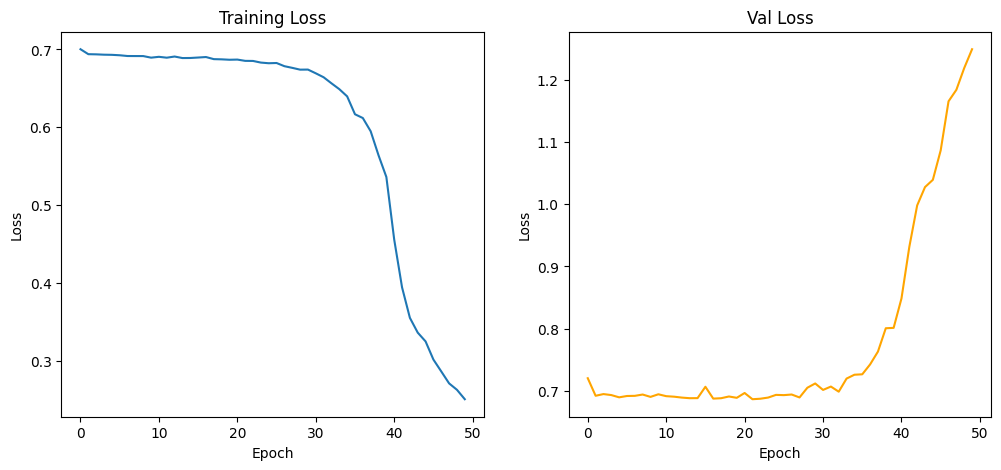

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

## __7. Evaluation__

In [38]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluation on val/test dataset
Val accuracy:  0.5226867193474382
Test accuracy:  0


## __8. Inference__

In [39]:
idx = 22
img_name = test_data[idx]['image_path']
img_path = os.path.join('val2014-resised', img_name)
question = test_data[idx]['question']
label = test_data[idx]['answer']

max_seq_len = 20
question_processed = torch.tensor(tokenize(question, max_seq_len)).unsqueeze(0).to(device)

img = Image.open(img_path).convert("RGB")
img_processed = data_transform['val'](img).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model(img_processed, question_processed)
    pred = torch.argmax(output, dim=1).item()

reverse_transform = transforms.Compose([
    transforms.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225]),
    transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.]),
    transforms.ToPILImage()
])
image_vis = reverse_transform(img_processed.squeeze(0).cpu())

origin_quest = detokenize(question_processed.squeeze(0).cpu().tolist())

plt.figure(figsize=(6, 6))
plt.imshow(image_vis)
plt.axis('off')
plt.show()

print(f'Question: {origin_quest}')
print(f'Groundtruth: {label}')
print(f'Predicted: {idx2label[pred]}')

IndexError: list index out of range